In [ ]:
from itertools import product
from functools import partial
from typing import Callable, NamedTuple, List, Tuple

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from estimator.precision import loss_precision
from generator.sequence import generate_random_sequence
from synchronizer.max_flow.max_flow import default_max_flow_synchronizer
from simulator.ground_truth.predefined import predefined_policies
from simulator.policy import policies_str
from synchronizer.alignment import Alignment
from signal_utils.consume import consume
from signal_utils.eval_loop import eval_loop
from signal_utils.test_signal import TestSignal
from signal_utils.sample import sample_uniform

## Test Tooling
### Samples for plots

Precision equals the number of correctly predicted loss events divided by the total number of predicted loss events.

In [ ]:
PrecisionSample = NamedTuple('PrecisionSample', [('precision', float), ('nw_condition', str), ('symbol_bits', str)])

def precision_sample_fn(nw_condition: str, symbol_bits: int) -> Callable[[TestSignal, Alignment], PrecisionSample]:
    def precision_sample(test_signal: TestSignal, alignment: Alignment) -> PrecisionSample:
        _precision = loss_precision(alignment, test_signal.ground_truth)
        return PrecisionSample(precision=_precision, nw_condition=nw_condition, symbol_bits=symbol_bits)
    return precision_sample

### Test Signal Generation

Note that we only generate signals that contain at least some events!

In [ ]:
def sample_signal_lengths():
    return sample_uniform(10, 30), 50

def generate_random_test_signal_fn(nw_condition: str, symbol_bits: int) -> Callable[[], TestSignal]:
    return partial(TestSignal.generate,
                   generator=generate_random_sequence(symbol_bits),
                   policies=predefined_policies[nw_condition],
                   sample_signal_lengths=sample_signal_lengths,
                   must_contain_events=True)

### Synchronizer

In [ ]:
synchronizer = default_max_flow_synchronizer

### Collecting Samples

In [ ]:
def collect_samples(nw_condition: str, symbol_bits: int, num_samples: int) -> List[PrecisionSample]:
    loop = partial(eval_loop,
                   generate_test_signal=generate_random_test_signal_fn(nw_condition, symbol_bits),
                   synchronizer=synchronizer,
                   postprocess=precision_sample_fn(nw_condition, symbol_bits))
    return consume(loop(), length=num_samples)

## Running Experiments
### Network Parameters
We use a predefined set of policies:

In [ ]:
for key, policies in predefined_policies.items():
    print(f'{key}:\n     {policies_str(policies)}\n')

normal:
     ge_loss(move_to_bad=0.005, move_to_good=0.7, drop_in_bad=0.5, drop_in_good=0.0075)
 --> ar1_uniform_delay(delay_bounds=(1, 5), prob=0.005)
 --> ar1_duplication(prob=0.001)

medium:
     ge_loss(move_to_bad=0.01, move_to_good=0.75, drop_in_bad=0.8, drop_in_good=0.01)
 --> ar1_uniform_delay(delay_bounds=(1, 5), prob=0.005)
 --> ar1_duplication(prob=0.002)

high:
     ge_loss(move_to_bad=0.035, move_to_good=0.75, drop_in_bad=0.8, drop_in_good=0.02)
 --> ar1_uniform_delay(delay_bounds=(1, 5), prob=0.01)
 --> ar1_duplication(prob=0.005)

severe:
     ge_loss(move_to_bad=0.075, move_to_good=0.75, drop_in_bad=0.8, drop_in_good=0.03)
 --> ar1_uniform_delay(delay_bounds=(1, 5), prob=0.05)
 --> ar1_duplication(prob=0.01)



### Variable Parameters

Because we only look at signals that actually contain events, it does not make much sense to look at the effect of differing network conditions here. We just assume `medium` condition, which has about 2% loss.

In [ ]:
nw_conditions = ['medium']
test_symbol_bits = [2, 3, 4, 8]

### Runs

In [ ]:
runs = 5000
samples = []
for nw_condition, symbol_bits in product(nw_conditions, test_symbol_bits):
    samples += collect_samples(nw_condition, symbol_bits, runs)

samples_df = pd.DataFrame(samples)

## Plots

### Symbol Bits vs Avg. Accuracy
What is the average precision (defined above) depending on symbol_bits and network condition?

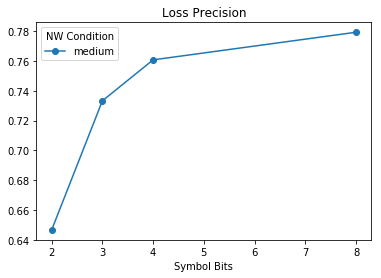

In [ ]:
agg_df = samples_df[samples_df['precision'] >= 0].groupby(['symbol_bits', 'nw_condition']).agg({
    'precision': ['mean']
}).unstack(1)
agg_df.columns = [col[2] for col in agg_df.columns]
agg_df.columns.name = 'NW Condition'
agg_df.index.name = 'Symbol Bits'
agg_df.plot(marker='o', title='Loss Precision')